In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/layoffs_clean.csv', sep=';')
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised_millions
0,Included Health,SF Bay Area,Healthcare,0,0.06,2022-07-25,Series E,United States,272
1,&Open,Dublin,Marketing,9,0.09,2022-11-17,Series A,Ireland,35
2,#Paid,Toronto,Marketing,19,0.17,2023-01-27,Series B,Canada,21
3,100 Thieves,Los Angeles,Consumer,12,NaN,2022-07-13,Series C,United States,120
4,10X Genomics,SF Bay Area,Healthcare,100,0.08,2022-08-04,Post-IPO,United States,242


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company                1995 non-null   object 
 1   location               1995 non-null   object 
 2   industry               1994 non-null   object 
 3   total_laid_off         1995 non-null   int64  
 4   percentage_laid_off    1572 non-null   float64
 5   date                   1994 non-null   object 
 6   stage                  1990 non-null   object 
 7   country                1995 non-null   object 
 8   funds_raised_millions  1995 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 140.4+ KB


In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df['percentage_laid_off'] = df['percentage_laid_off'].fillna(df['percentage_laid_off'].median())
df['percentage_laid_off'] = df['percentage_laid_off'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   company                1995 non-null   object        
 1   location               1995 non-null   object        
 2   industry               1994 non-null   object        
 3   total_laid_off         1995 non-null   int64         
 4   percentage_laid_off    1995 non-null   int64         
 5   date                   1994 non-null   datetime64[ns]
 6   stage                  1990 non-null   object        
 7   country                1995 non-null   object        
 8   funds_raised_millions  1995 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 140.4+ KB


### The Big Picture: When did layoffs peak?

/tmp/ipython-input-4010645212.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['total_laid_off']


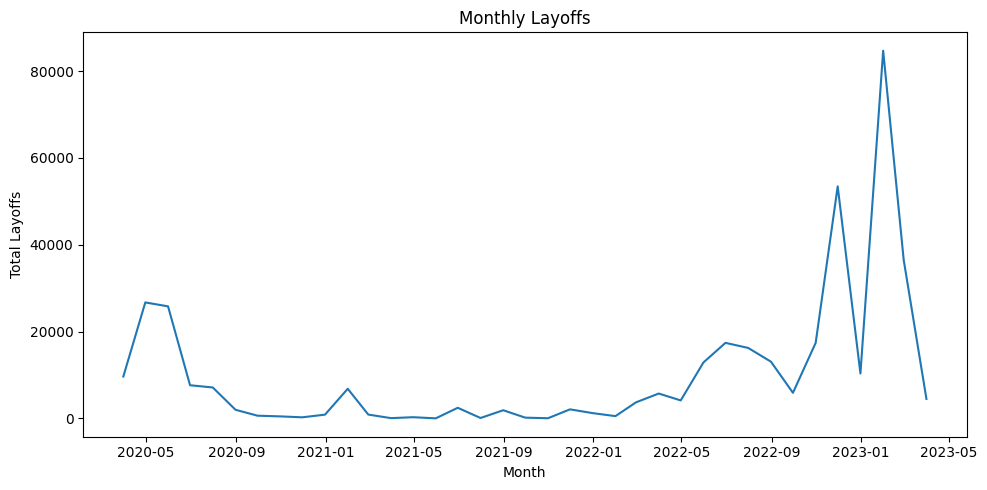

In [5]:
import matplotlib.pyplot as plt

# --- Prep ---
tmp = df.copy()
tmp = tmp.dropna(subset=['date'])  # remove rows without date
monthly = (tmp.set_index('date')
              .resample('M')['total_laid_off']
              .sum()
              .reset_index())

# --- Plot: clean, professional line chart ---
plt.figure(figsize=(10, 5))
plt.plot(monthly['date'], monthly['total_laid_off'])
plt.title('Monthly Layoffs')
plt.xlabel('Month')
plt.ylabel('Total Layoffs')
plt.tight_layout()
plt.show()

peak time when company cut off people was in may 2023 whereas from 2020 until may 2022 the trend was almost consistent throught the year

Once we know when the spike happened, the next logical question is: “Which industries drove this spike?”

### Breaking it down: Which industries drove the peak?

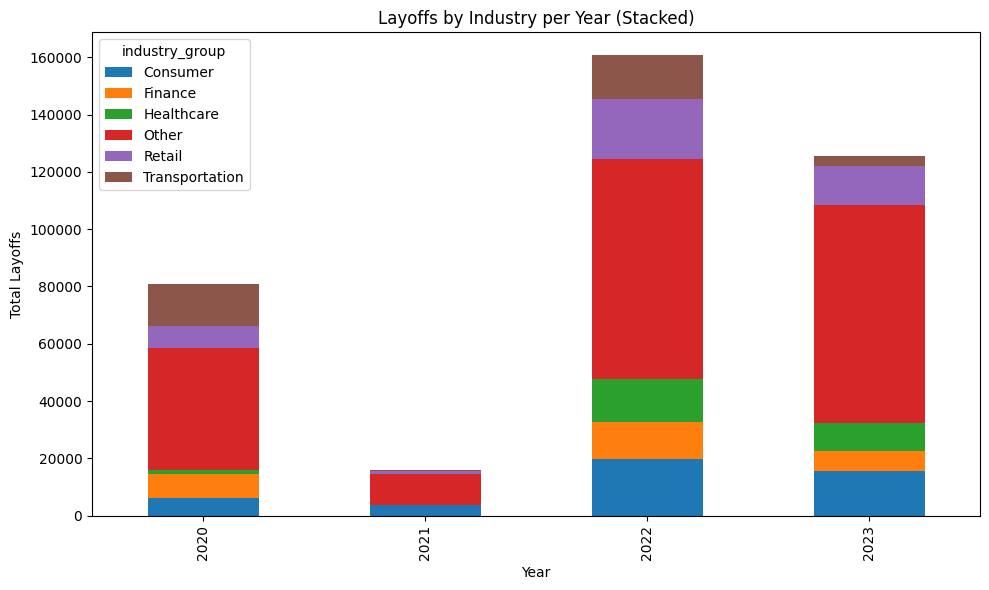

In [6]:
tmp = df.copy()
tmp = tmp.dropna(subset=['date'])
tmp['year'] = tmp['date'].dt.year

# Top 6 industries
top_industries = (tmp.groupby('industry')['total_laid_off']
                    .sum()
                    .nlargest(6)
                    .index)

tmp['industry_group'] = tmp['industry'].fillna('Unknown')
tmp.loc[~tmp['industry_group'].isin(top_industries), 'industry_group'] = 'Other'

year_ind = (tmp.groupby(['year', 'industry_group'])['total_laid_off']
              .sum()
              .unstack(fill_value=0)
              .sort_index())

# --- Plot: stacked bar ---
ax = year_ind.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Layoffs by Industry per Year (Stacked)')
ax.set_xlabel('Year')
ax.set_ylabel('Total Layoffs')
plt.tight_layout()
plt.show()

From the stacked bar we can see layoffs were dominated by the “Other” sector across all years. 2020 had large cuts in Transportation and Finance, while 2021 was much quieter overall. Layoffs spiked again in 2022 and stayed high in 2023, spreading across multiple industries but still led by the “Other” group.

Once we know the industry, the next question is naturally: “Which companies inside those industries cut the most?”

In [7]:
# --- Build the table ---
year_ind = (tmp.groupby(['year', 'industry_group'])['total_laid_off']
              .sum()
              .unstack(fill_value=0)
              .sort_index())

# --- See the values in console ---
print(year_ind)

industry_group  Consumer  Finance  Healthcare  Other  Retail  Transportation
year                                                                        
2020                6063     8624        1125  42528    8002           14656
2021                3600        0           0  10935    1088             200
2022               19856    12684       15058  76922   20914           15227
2023               15663     7036        9770  75934   13609            3665


### Zoom-in: Which companies cut the most?


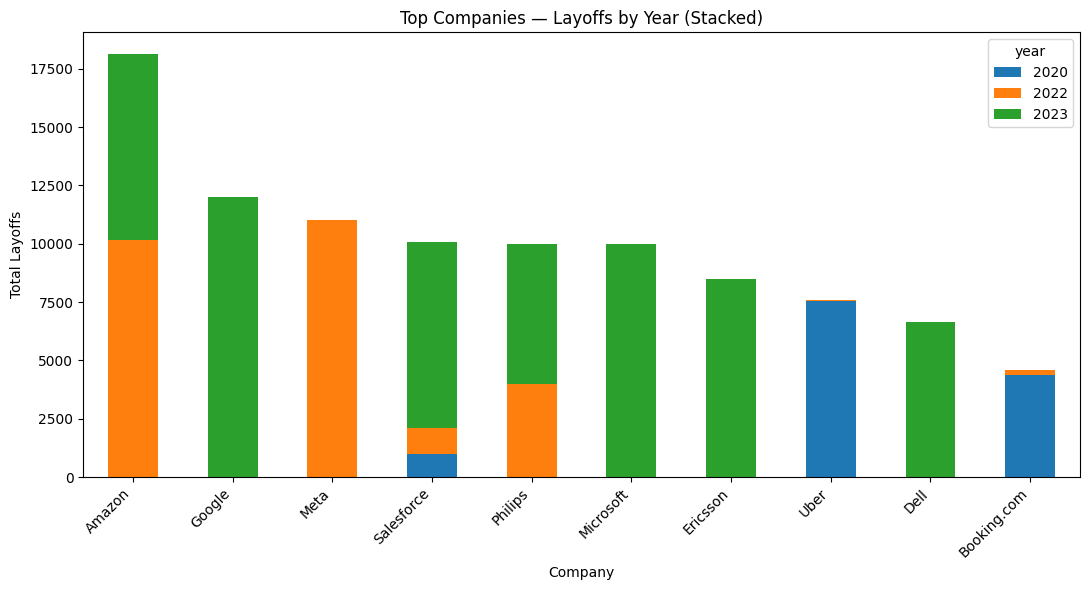

In [8]:
tmp = df.copy()
tmp = tmp.dropna(subset=['date'])
tmp['year'] = tmp['date'].dt.year

# Top 10 companies
top_companies = (tmp.groupby('company')['total_laid_off']
                   .sum()
                   .nlargest(10)
                   .index)

comp_year = (tmp[tmp['company'].isin(top_companies)]
               .groupby(['company', 'year'])['total_laid_off']
               .sum()
               .unstack(fill_value=0))

# Sort by total layoffs
comp_year = comp_year.assign(_Total=comp_year.sum(axis=1)) \
                     .sort_values('_Total', ascending=False) \
                     .drop(columns=['_Total'])

# --- Plot: stacked bar ---
ax = comp_year.plot(kind='bar', stacked=True, figsize=(11, 6))
ax.set_title('Top Companies — Layoffs by Year (Stacked)')
ax.set_xlabel('Company')
ax.set_ylabel('Total Layoffs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Amazon recorded the highest overall layoffs across 2022 and 2023 combined, with significant cuts in both years. In 2023, Google led with the largest single-year layoffs, while in 2022, Meta reported the highest layoffs among all companies.

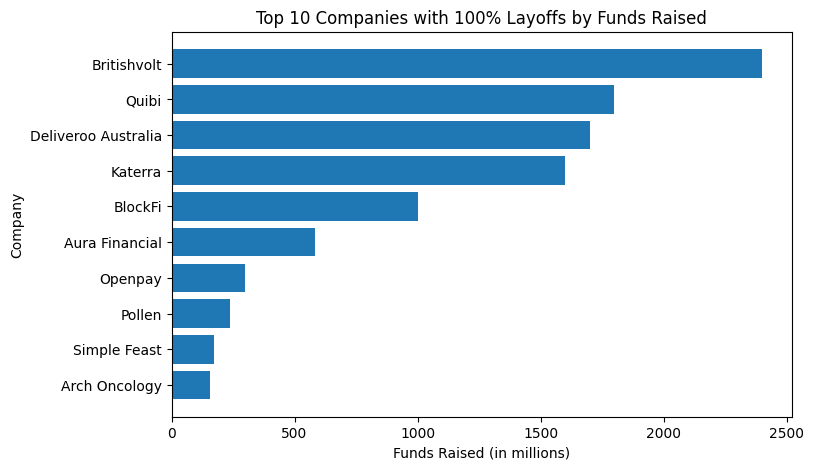

In [9]:
# Filter only companies with 100% layoffs
df_full_layoff = df[df['percentage_laid_off'] == 1]

# Sort by funds raised
df_full_layoff = df_full_layoff.sort_values(by="funds_raised_millions", ascending=False)

# Keep only top 10
df_top10 = df_full_layoff.head(10)

# Plot
plt.figure(figsize=(8,5))
plt.barh(df_top10['company'], df_top10['funds_raised_millions'])
plt.xlabel("Funds Raised (in millions)")
plt.ylabel("Company")
plt.title("Top 10 Companies with 100% Layoffs by Funds Raised")
plt.gca().invert_yaxis()
plt.show()

Heavily funded startups in transport, food, crypto and healthcare once looked unstoppable. But many collapsed, shut down or laid off staff. Even with billions raised, success doesn’t last without a solid business model.